# Exploratory Data Analysis: ECTSum Summarization Dataset

This notebook performs a comprehensive exploratory data analysis of the ECTSum dataset, which we'll be using for the sentiment analysis task in our LLM distillation thesis.

Dataset: https://huggingface.co/datasets/mrSoul7766/ECTSum

Paper: https://arxiv.org/abs/2210.12467

### Setup and Imports

In [53]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer
from IPython.display import display

# Set up plot aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)

# move one directory up to import modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src.prompts.summary import get_summmary_prompt
from src.data.data_manager import SummaryManager

### Loading dataset

In [54]:
dataset = SummaryManager.load_original_data()
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df = pd.concat([df_train, df_test], ignore_index=True)

### Dataset Overview

Dataset Shape: (2176, 2)

Dataset Sample:


,text,summary
0,"For those of you that have not, it is availabl...",q1 revenue rose 11.1 percent to $481.1 million...
1,"I'm joined by Tom Greco, our President and Chi...",q1 adjusted earnings per share $3.34.\nq1 sale...



Missing Values:


text       0
summary    0
dtype: int64


Basic Statistics of Text Lengths:


,summary_length,text_length
count,2176.000000,2176.000000
mean,272.213235,17798.836857
std,214.055570,6692.082200
min,16.000000,1540.000000
25%,120.000000,13085.000000
50%,217.000000,17296.000000
75%,363.000000,21846.750000
max,1675.000000,70127.000000



Compression Ratio (summary length / text length):


count    2176.000000
mean        0.016866
std         0.014169
min         0.000487
25%         0.007214
50%         0.013295
75%         0.022330
max         0.145165
Name: compression_ratio, dtype: float64

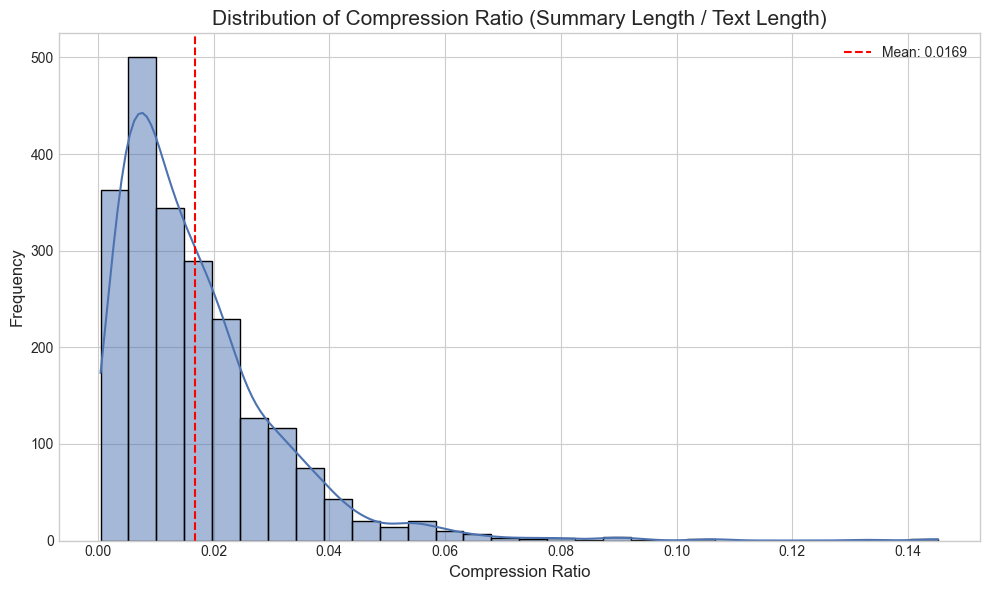

In [55]:
# Print basic dataset information
print(f"Dataset Shape: {df.shape}")
print("\nDataset Sample:")
display(df.head(2))

# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())

# Basic summary statistics
print("\nBasic Statistics of Text Lengths:")
df['summary_length'] = df['summary'].apply(len)
df['text_length'] = df['text'].apply(len)
display(df[['summary_length', 'text_length']].describe())

# Compression ratio (summary length / text length)
df['compression_ratio'] = df['summary_length'] / df['text_length']
print("\nCompression Ratio (summary length / text length):")
display(df['compression_ratio'].describe())

# Visualize compression ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['compression_ratio'], kde=True, bins=30)
plt.title('Distribution of Compression Ratio (Summary Length / Text Length)', fontsize=15)
plt.xlabel('Compression Ratio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df['compression_ratio'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df["compression_ratio"].mean():.4f}')
plt.legend()
plt.tight_layout()
plt.show()

### Token Count Analysis

Calculating token counts: 100%|██████████| 2176/2176 [00:32<00:00, 66.70it/s]

Token Count Statistics:


,Summary Tokens,Transcript Tokens,Prompt + Transcript Tokens,Full Sequence Tokens
count,2176.000000,2176.000000,2176.000000,2176.000000
mean,74.589154,3529.068474,4012.054688,4086.643842
std,52.522532,1312.108790,1312.108545,1323.475491
min,8.000000,288.000000,771.000000,782.000000
25%,36.000000,2638.500000,3121.750000,3182.500000
50%,62.000000,3409.000000,3892.000000,3970.500000
75%,100.000000,4314.500000,4797.500000,4893.500000
max,388.000000,13800.000000,14283.000000,14328.000000


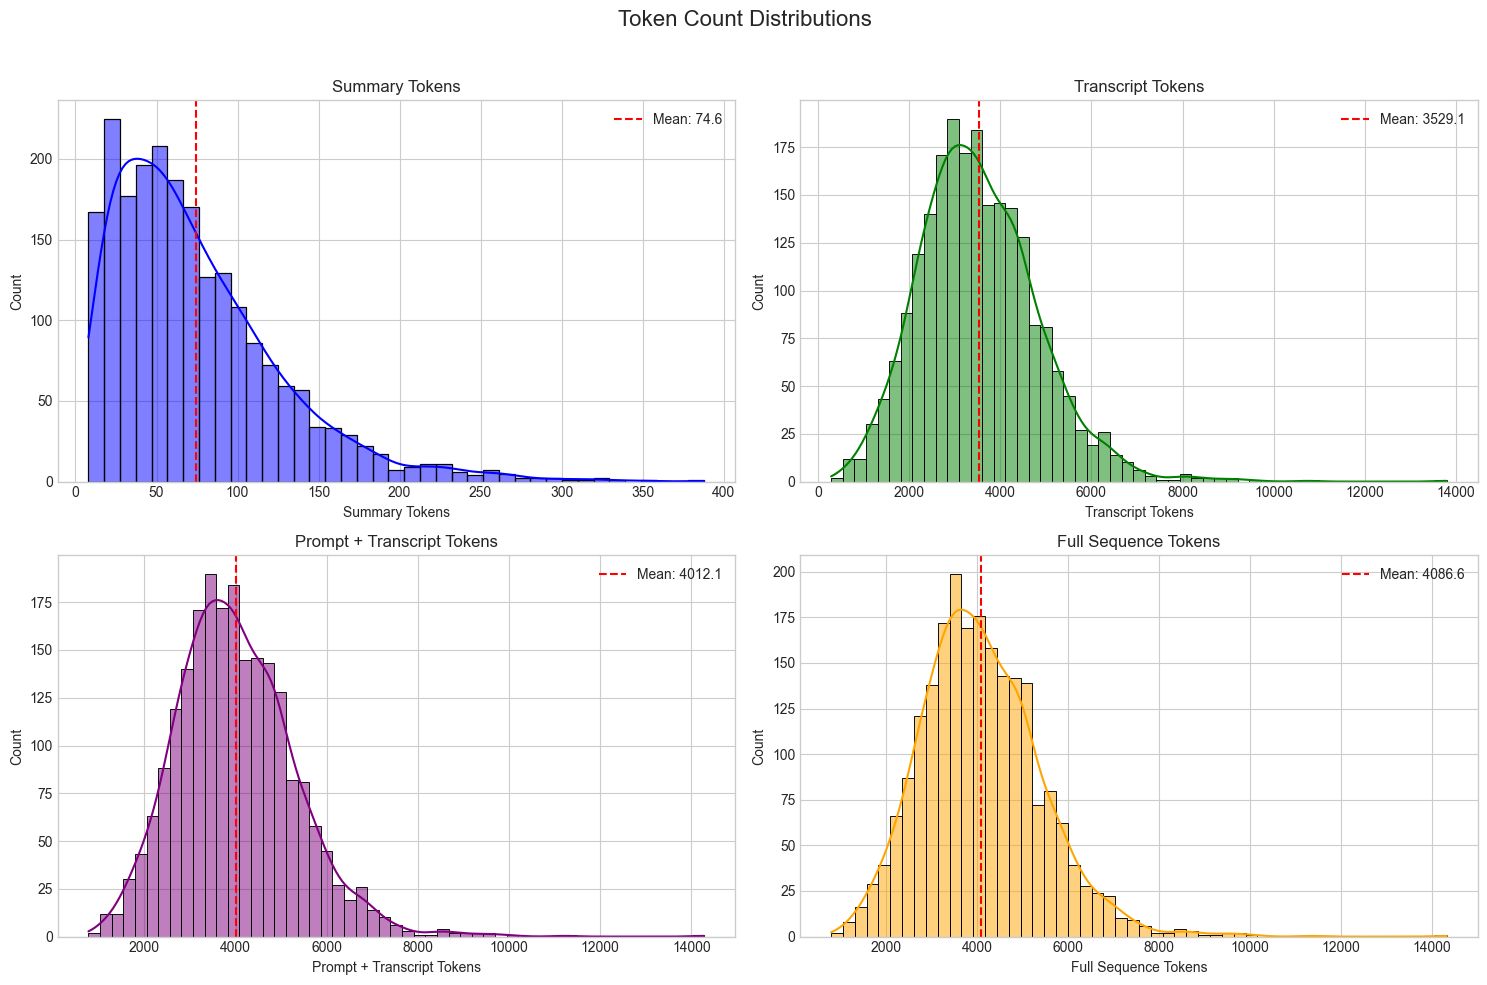

/var/folders/4v/mg6gp3rx0yj803ddxqcd01bc0000gn/T/ipykernel_67769/3706440958.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variable', y='value', data=token_df_melt, palette='viridis')


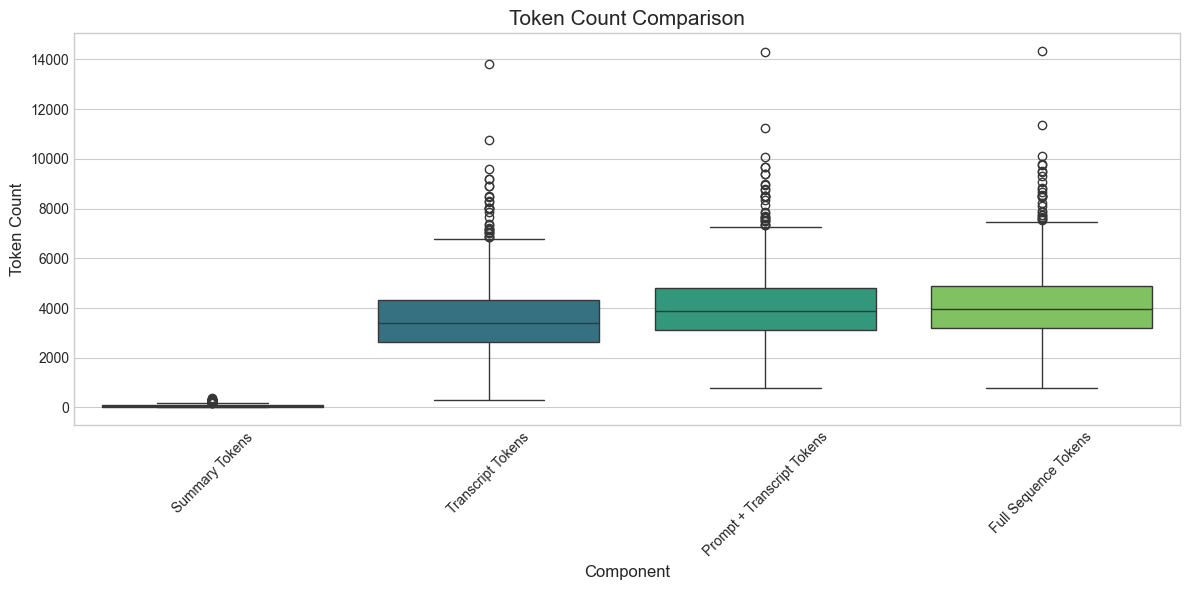


Number of examples exceeding 4096 token context window: 1007
Examples with longest token counts:


,Summary Tokens,Transcript Tokens,Prompt + Transcript Tokens,Full Sequence Tokens
1285,45,13800,14283,14328
534,141,10743,11226,11367
625,12,9605,10088,10100
1634,122,9203,9686,9808
1410,85,9197,9680,9765


In [56]:
# Load the tokenizer (using the same one we'll use for our models)
model_name = "meta-llama/Llama-3.2-1B-Instruct"  # Change this to match your model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize lists to store token counts
summary_token_counts = []
text_token_counts = []
prompt_token_counts = []
full_sequence_token_counts = []

# Sample size (use all if dataset is small, otherwise limit to a reasonable number)
sample_size = min(len(df), 2176)  # Limiting to 500 due to potentially long texts
sample_indices = np.random.choice(len(df), sample_size, replace=False)

# Calculate token counts for each example
for idx in tqdm(sample_indices, desc="Calculating token counts"):
    # Summary text
    summary_text = df.iloc[idx]['summary']
    summary_tokens = tokenizer.encode(summary_text)
    summary_token_counts.append(len(summary_tokens))
    
    # Original transcript text
    transcript_text = df.iloc[idx]['text']
    text_tokens = tokenizer.encode(transcript_text)
    text_token_counts.append(len(text_tokens))
    
    # Input text + prompt
    prompt_text = get_summmary_prompt(transcript_text)
    prompt_tokens = tokenizer.encode(prompt_text)
    prompt_token_counts.append(len(prompt_tokens))
    
    # Total sequence length (prompt + summary)
    full_sequence_tokens = len(prompt_tokens) + len(summary_tokens)
    full_sequence_token_counts.append(full_sequence_tokens)

# Create a DataFrame for the token counts
token_df = pd.DataFrame({
    'Summary Tokens': summary_token_counts,
    'Transcript Tokens': text_token_counts,
    'Prompt + Transcript Tokens': prompt_token_counts,
    'Full Sequence Tokens': full_sequence_token_counts
})

# Display token count statistics
print("Token Count Statistics:")
display(token_df.describe())

# Create visualizations for token counts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Token Count Distributions', fontsize=16)

# Summary tokens
sns.histplot(token_df['Summary Tokens'], kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Summary Tokens')
axes[0, 0].axvline(token_df['Summary Tokens'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {token_df["Summary Tokens"].mean():.1f}')
axes[0, 0].legend()

# Transcript tokens
sns.histplot(token_df['Transcript Tokens'], kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Transcript Tokens')
axes[0, 1].axvline(token_df['Transcript Tokens'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {token_df["Transcript Tokens"].mean():.1f}')
axes[0, 1].legend()

# Prompt + Transcript tokens
sns.histplot(token_df['Prompt + Transcript Tokens'], kde=True, ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Prompt + Transcript Tokens')
axes[1, 0].axvline(token_df['Prompt + Transcript Tokens'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {token_df["Prompt + Transcript Tokens"].mean():.1f}')
axes[1, 0].legend()

# Full sequence tokens
sns.histplot(token_df['Full Sequence Tokens'], kde=True, ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Full Sequence Tokens')
axes[1, 1].axvline(token_df['Full Sequence Tokens'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {token_df["Full Sequence Tokens"].mean():.1f}')
axes[1, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Create a boxplot for token count comparison
plt.figure(figsize=(12, 6))
token_df_melt = pd.melt(token_df)
sns.boxplot(x='variable', y='value', data=token_df_melt, palette='viridis')
plt.title('Token Count Comparison', fontsize=15)
plt.xlabel('Component', fontsize=12)
plt.ylabel('Token Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check if any examples exceed a common context window size (e.g., 4096 tokens)
context_window = 4096
exceeding = token_df[token_df['Full Sequence Tokens'] > context_window]
print(f"\nNumber of examples exceeding {context_window} token context window: {len(exceeding)}")
if len(exceeding) > 0:
    print("Examples with longest token counts:")
    display(exceeding.sort_values('Full Sequence Tokens', ascending=False).head())


### Context Window Analysis

,Context Window,Transcript Exceeding Count,Transcript Exceeding %,Prompt + Transcript Exceeding Count,Prompt + Transcript Exceeding %
0,2048,1938,89.062500,2077,95.450368
1,4096,666,30.606618,942,43.290441
2,6144,76,3.492647,121,5.560662
3,8192,11,0.505515,16,0.735294
4,16384,0,0.000000,0,0.000000
5,32768,0,0.000000,0,0.000000


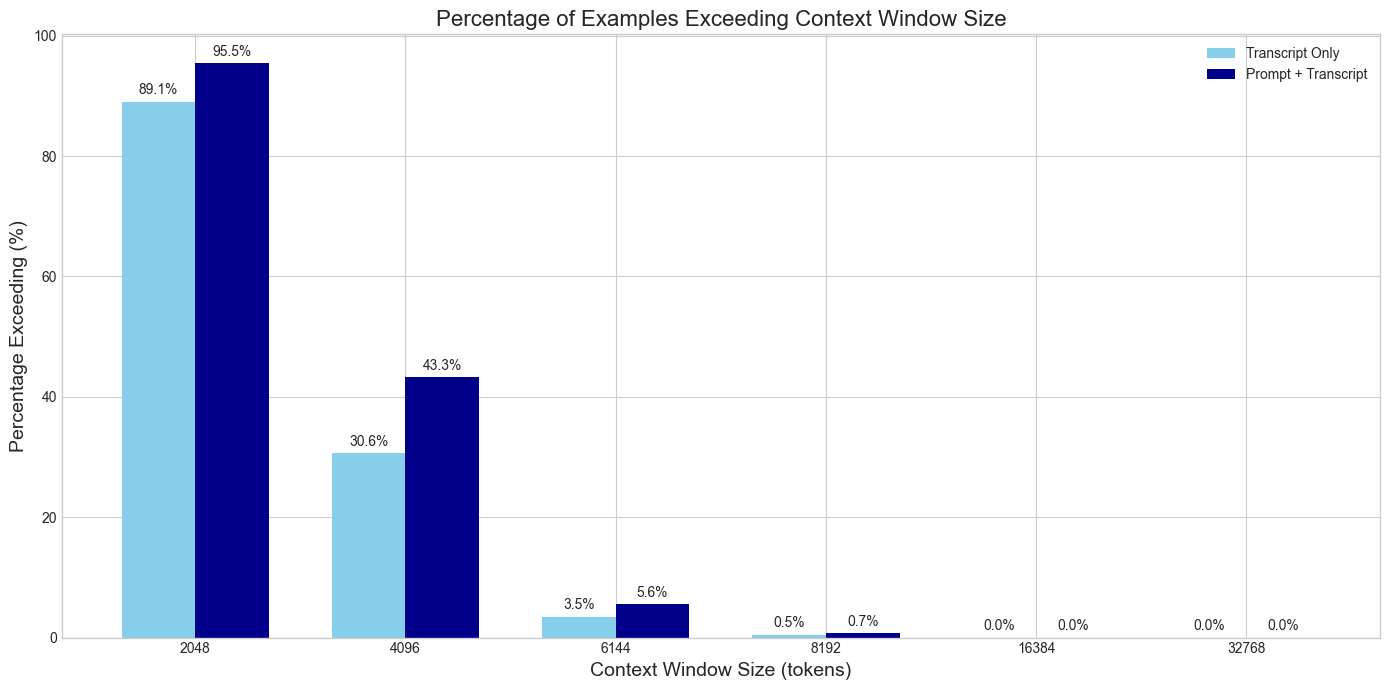


Implications for Model Architecture Selection:
- Average transcript token count: 3529 tokens
- Average summary token count: 75 tokens
- Average prompt + transcript token count: 4012 tokens
- Average full sequence token count: 4087 tokens
- Average compression ratio: 0.0211

Percentage of examples exceeding common context windows:
- 2048 tokens: 89.1% of transcripts, 95.5% with prompt, 95.9% full sequence
- 4096 tokens: 30.6% of transcripts, 43.3% with prompt, 46.3% full sequence
- 6144 tokens: 3.5% of transcripts, 5.6% with prompt, 6.2% full sequence
- 8192 tokens: 0.5% of transcripts, 0.7% with prompt, 0.8% full sequence

Architecture Recommendations:
- Models with 4K context windows would be sufficient for most examples
- 43.3% of examples would require truncation with 4K context


In [58]:
# Analyze the impact of context window limitations
context_windows = [2048, 4096, 6144, 8192, 16384, 32768]
window_stats = []

for window in context_windows:
    # Analyze transcript tokens (raw input content)
    transcript_exceeding = sum(token_df['Transcript Tokens'] > window)
    transcript_exceeding_pct = transcript_exceeding / len(token_df) * 100
    
    # Analyze prompt + transcript tokens (actual model input)
    prompt_exceeding = sum(token_df['Prompt + Transcript Tokens'] > window)
    prompt_exceeding_pct = prompt_exceeding / len(token_df) * 100
    
    window_stats.append({
        'Context Window': window,
        'Transcript Exceeding Count': transcript_exceeding,
        'Transcript Exceeding %': transcript_exceeding_pct,
        'Prompt + Transcript Exceeding Count': prompt_exceeding,
        'Prompt + Transcript Exceeding %': prompt_exceeding_pct
    })

window_df = pd.DataFrame(window_stats)
display(window_df)

# Plot the percentage of transcripts exceeding different context windows
fig, ax = plt.subplots(figsize=(14, 7))
x = window_df['Context Window'].astype(str)
width = 0.35

# Plot transcript tokens
bars1 = ax.bar(np.arange(len(x)) - width/2, window_df['Transcript Exceeding %'], 
               width, label='Transcript Only', color='skyblue')

# Plot prompt + transcript tokens
bars2 = ax.bar(np.arange(len(x)) + width/2, window_df['Prompt + Transcript Exceeding %'], 
               width, label='Prompt + Transcript', color='darkblue')

ax.set_title('Percentage of Examples Exceeding Context Window Size', fontsize=16)
ax.set_xlabel('Context Window Size (tokens)', fontsize=14)
ax.set_ylabel('Percentage Exceeding (%)', fontsize=14)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.legend()

# Add percentage labels
for i, bars in enumerate([bars1, bars2]):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Analyze implications for model architecture selection
print("\nImplications for Model Architecture Selection:")

# Average metrics
avg_transcript = token_df['Transcript Tokens'].mean()
avg_summary = token_df['Summary Tokens'].mean()
avg_prompt_transcript = token_df['Prompt + Transcript Tokens'].mean()
avg_full_seq = token_df['Full Sequence Tokens'].mean()

print(f"- Average transcript token count: {avg_transcript:.0f} tokens")
print(f"- Average summary token count: {avg_summary:.0f} tokens")
print(f"- Average prompt + transcript token count: {avg_prompt_transcript:.0f} tokens")
print(f"- Average full sequence token count: {avg_full_seq:.0f} tokens")
print(f"- Average compression ratio: {avg_summary / avg_transcript:.4f}")

print("\nPercentage of examples exceeding common context windows:")
for window in [2048, 4096, 6144, 8192]:
    transcript_pct = sum(token_df['Transcript Tokens'] > window) / len(token_df) * 100
    prompt_pct = sum(token_df['Prompt + Transcript Tokens'] > window) / len(token_df) * 100
    full_pct = sum(token_df['Full Sequence Tokens'] > window) / len(token_df) * 100
    
    print(f"- {window} tokens: {transcript_pct:.1f}% of transcripts, {prompt_pct:.1f}% with prompt, {full_pct:.1f}% full sequence")

# Recommendation for architecture based on context window needs
print("\nArchitecture Recommendations:")
if avg_prompt_transcript > 8192:
    print("- Consider larger context window models (16K+ tokens) for full dataset coverage")
elif avg_prompt_transcript > 4096:
    print("- Models with 8K context windows will handle most examples")
    print(f"- {sum(token_df['Prompt + Transcript Tokens'] > 8192) / len(token_df) * 100:.1f}% of examples would require truncation with 8K context")
else:
    print("- Models with 4K context windows would be sufficient for most examples")
    print(f"- {sum(token_df['Prompt + Transcript Tokens'] > 4096) / len(token_df) * 100:.1f}% of examples would require truncation with 4K context")